## dwt_signal_decomposition.py

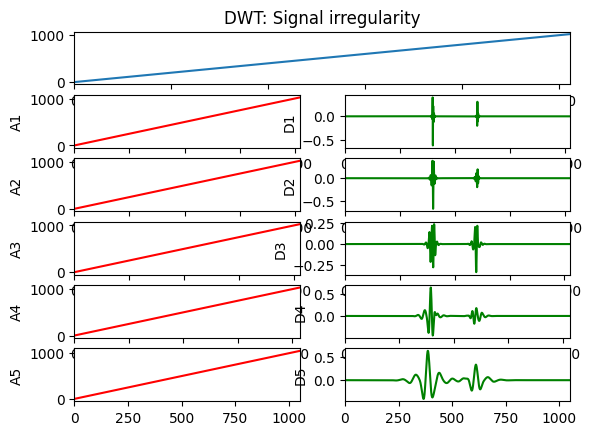

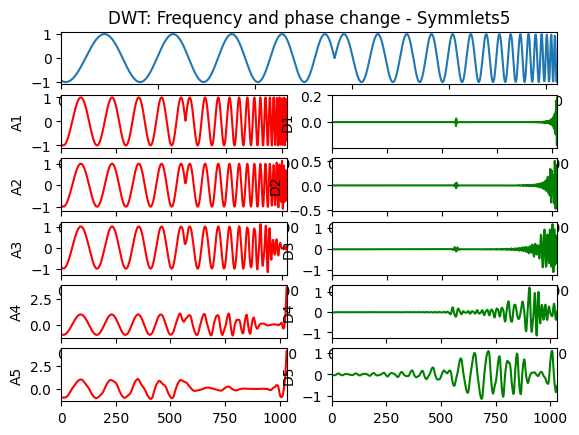

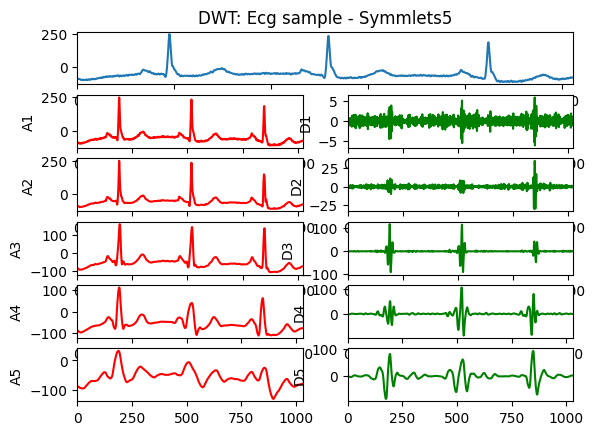

In [3]:
#!/usr/bin/env python

import matplotlib.pyplot as plt
import numpy as np

import pywt
import pywt.data

ecg = pywt.data.ecg()

data1 = np.concatenate((np.arange(1, 400),
                        np.arange(398, 600),
                        np.arange(601, 1024)))
x = np.linspace(0.082, 2.128, num=1024)[::-1]
data2 = np.sin(40 * np.log(x)) * np.sign(np.log(x))

mode = pywt.Modes.smooth


def plot_signal_decomp(data, w, title):
    """Decompose and plot a signal S.

    S = An + Dn + Dn-1 + ... + D1
    """
    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []
    for i in range(5):
        (a, d) = pywt.dwt(a, w, mode)
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))

    fig = plt.figure()
    ax_main = fig.add_subplot(len(rec_a) + 1, 1, 1)
    ax_main.set_title(title)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) + 1, 2, 3 + i * 2)
        ax.plot(y, 'r')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("A%d" % (i + 1))

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) + 1, 2, 4 + i * 2)
        ax.plot(y, 'g')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("D%d" % (i + 1))


plot_signal_decomp(data1, 'coif5', "DWT: Signal irregularity")
plot_signal_decomp(data2, 'sym5',
                   "DWT: Frequency and phase change - Symmlets5")
plot_signal_decomp(ecg, 'sym5', "DWT: Ecg sample - Symmlets5")


plt.show()

## plot_wavelets.py

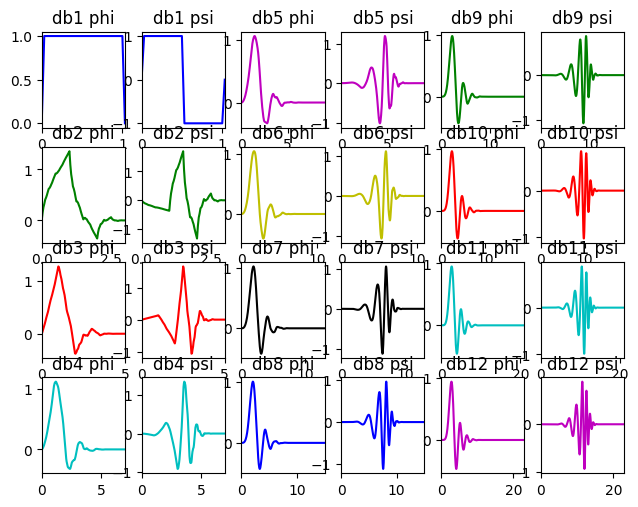

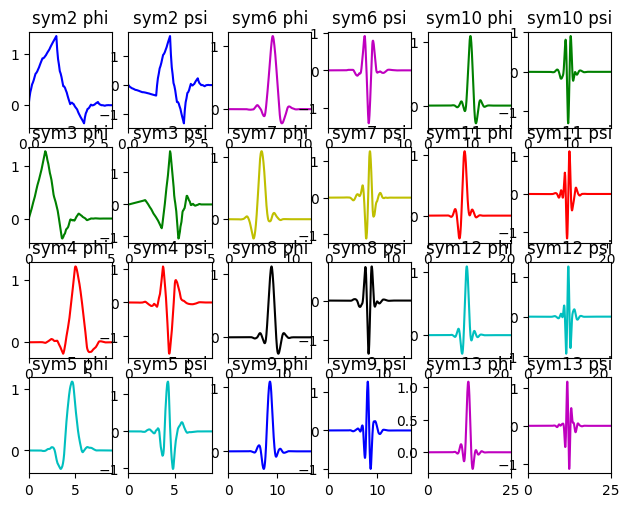

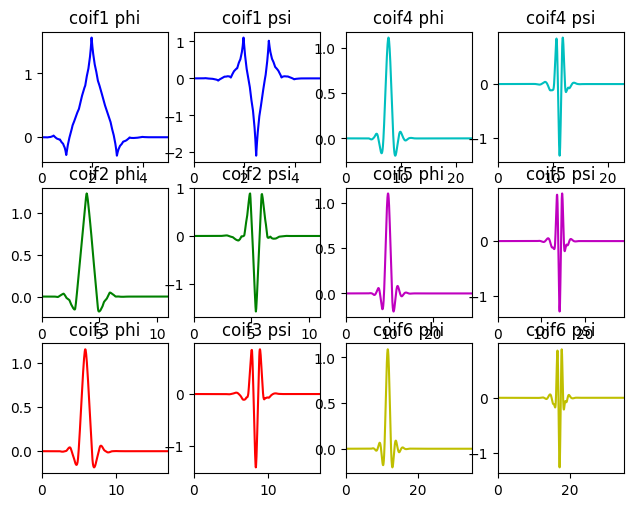

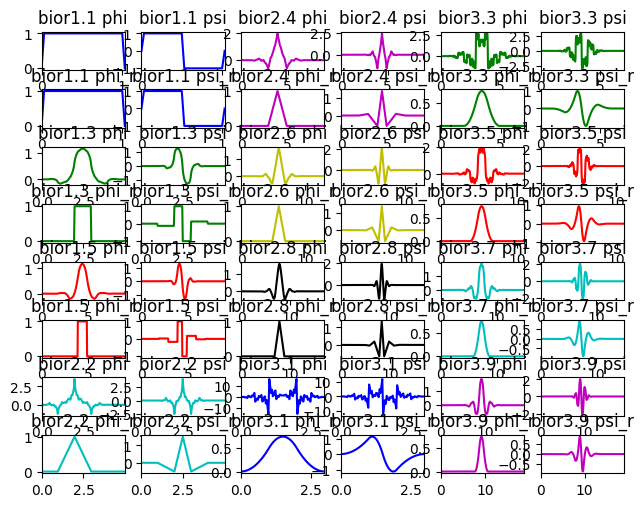

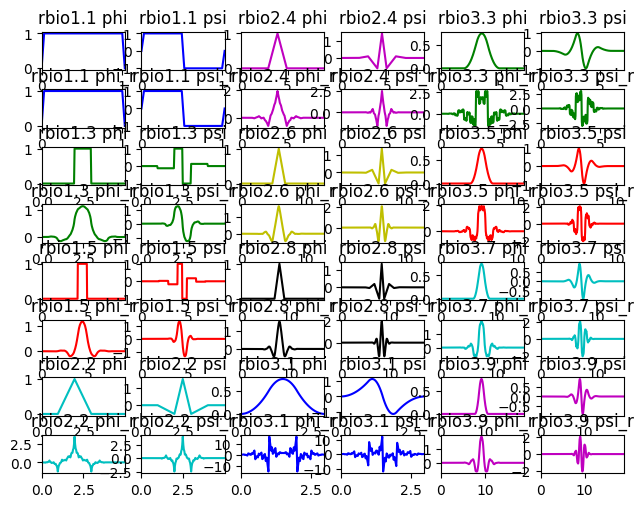

In [1]:
#!/usr/bin/env python

# Plot scaling and wavelet functions for db, sym, coif, bior and rbio families

import itertools

import matplotlib.pyplot as plt

import pywt

plot_data = [('db', (4, 3)),
             ('sym', (4, 3)),
             ('coif', (3, 2))]


for family, (rows, cols) in plot_data:
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2, bottom=.02, left=.06,
                        right=.97, top=.94)
    colors = itertools.cycle('bgrcmyk')

    wnames = pywt.wavelist(family)
    i = iter(wnames)
    for col in range(cols):
        for row in range(rows):
            try:
                wavelet = pywt.Wavelet(next(i))
            except StopIteration:
                break
            phi, psi, x = wavelet.wavefun(level=5)

            color = next(colors)
            ax = fig.add_subplot(rows, 2 * cols, 1 + 2 * (col + row * cols))
            ax.set_title(wavelet.name + " phi")
            ax.plot(x, phi, color)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(rows, 2*cols, 1 + 2*(col + row*cols) + 1)
            ax.set_title(wavelet.name + " psi")
            ax.plot(x, psi, color)
            ax.set_xlim(min(x), max(x))

for family, (rows, cols) in [('bior', (4, 3)), ('rbio', (4, 3))]:
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.5, wspace=0.2, bottom=.02, left=.06,
                        right=.97, top=.94)

    colors = itertools.cycle('bgrcmyk')
    wnames = pywt.wavelist(family)
    i = iter(wnames)
    for col in range(cols):
        for row in range(rows):
            try:
                wavelet = pywt.Wavelet(next(i))
            except StopIteration:
                break
            phi, psi, phi_r, psi_r, x = wavelet.wavefun(level=5)
            row *= 2

            color = next(colors)
            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
            ax.set_title(wavelet.name + " phi")
            ax.plot(x, phi, color)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(2*rows, 2*cols, 2*(1 + col + row*cols))
            ax.set_title(wavelet.name + " psi")
            ax.plot(x, psi, color)
            ax.set_xlim(min(x), max(x))

            row += 1
            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols))
            ax.set_title(wavelet.name + " phi_r")
            ax.plot(x, phi_r, color)
            ax.set_xlim(min(x), max(x))

            ax = fig.add_subplot(2*rows, 2*cols, 1 + 2*(col + row*cols) + 1)
            ax.set_title(wavelet.name + " psi_r")
            ax.plot(x, psi_r, color)
            ax.set_xlim(min(x), max(x))

plt.show()

## Объяснение вейвлет-преобразования

In [33]:
import numpy as np
import pywt

def manual_wavelet_transform(x, wavelet_name):
    """
    Ручное вычисление аппроксимирующих и детализирующих коэффициентов
    с учётом симметричного паддинга и подвыборки.

    Args:
        x (array-like): Входной сигнал.
        wavelet_name (str): Название вейвлета (например, 'db1').

    Returns:
        tuple: (approx_coeffs, detail_coeffs)
    """
    # Создаем объект вейвлета
    wavelet = pywt.Wavelet(wavelet_name)
    approx_filter = wavelet.dec_lo  # Фильтр аппроксимации
    detail_filter = wavelet.dec_hi  # Фильтр детализации

    # Определяем паддинг (симметричный)
    pad_width = len(approx_filter) - 1
    x_padded = np.pad(x, (pad_width, pad_width), mode='symmetric')

    # Выполняем свертку для аппроксимации и детализации
    approx_conv = np.convolve(x_padded, approx_filter, mode='valid')
    detail_conv = np.convolve(x_padded, detail_filter, mode='valid')

    # Подвыборка: берем каждый второй элемент, начиная с индекса 0 для аппроксимации
    approx_coeffs = approx_conv[1::2]
    # Для детализации — каждый второй элемент, начиная с индекса 1 (аналогично PyWavelets)
    detail_coeffs = detail_conv[1::2]

    return approx_coeffs, detail_coeffs

In [112]:
import numpy as np
import pywt

def symmetric_pad(data, pad_width):
    """Добавляет симметричный паддинг к массиву.
    
    Args:
        data (list): Входной сигнал.
        pad_width (int): Количество элементов для добавления с каждой стороны.
        
    Returns:
        list: Массив с симметричным паддингом.
    """
    # Отражаем начало и конец массива
    left_pad = data[0:pad_width][::-1]   # Зеркальное отражение начала
    right_pad = data[-pad_width:][::-1]  # Зеркальное отражение конца
    return left_pad + data + right_pad

def manual_convolve(signal, kernel):
    """Ручная реализация свертки в режиме 'valid'.
    
    Args:
        signal (list): Входной сигнал с паддингом.
        kernel (list): Фильтр (например, dec_lo или dec_hi).
        
    Returns:
        list: Результат свертки.
    """
    result = []
    kernel = [float(k) for k in kernel]  # Преобразуем в float
    kernel_length = len(kernel)
    for i in range(len(signal) - kernel_length + 1):
        # Вычисляем скалярное произведение вручную
        conv_sum = 0.0
        for j in range(kernel_length):
            conv_sum += float(signal[i+j]) * kernel[-(j + 1)]
        result.append(conv_sum)
    return result

def manual_wavelet_transform_explicit(x, wavelet_name):
    """Явная реализация одиночного уровня вейвлет-преобразования.
    
    Args:
        x (array-like): Входной сигнал.
        wavelet_name (str): Название вейвлета (например, 'db1').
        
    Returns:
        tuple: (approx_coeffs, detail_coeffs)
    """
    # 1. Получаем фильтры вейвлета
    wavelet = pywt.Wavelet(wavelet_name)
    approx_filter = wavelet.dec_lo  # Фильтр аппроксимации
    detail_filter = wavelet.dec_hi  # Фильтр детализации

    # 2. Добавляем симметричный паддинг
    pad_width = len(approx_filter) - 1
    x_padded = symmetric_pad(x, pad_width)
    
    # 3. Выполняем свертку для аппроксимации и детализации
    approx_conv = manual_convolve(x_padded, approx_filter)
    detail_conv = manual_convolve(x_padded, detail_filter)
    
    # 4. Подвыборка (аналогично PyWavelets)
    approx_coeffs = approx_conv[1::2]  # Начиная с индекса 1
    detail_coeffs = detail_conv[1::2]  # Начиная с индекса 1
    
    return approx_coeffs, detail_coeffs

In [ ]:
def multi_level_wavelet_transform(x, wavelet_name, level):
    """
    Многоуровневое вейвлет-преобразование с ручным вычислением коэффициентов.
    
    Args:
        x (array-like): Входной сигнал.
        wavelet_name (str): Название вейвлета (например, 'db1').
        level (int): Количество уровней разложения.
    
    Returns:
        list: Список вида [cD_1, cD_2, ..., cD_level, cA_level], 
              где cA_level — аппроксимация последнего уровня.
    """
    coeffs = []
    current_a = np.array(x, dtype=np.float64)  # Исходные данные (0 уровень)
    
    for _ in range(level):
        # Выполняем преобразование для текущего уровня
        cA, cD = manual_wavelet_transform_explicit(current_a if type(current_a) == list else current_a.tolist(), wavelet_name)
        coeffs.append(cD)
        current_a = cA  # Переходим к следующему уровню
    
    # Добавляем финальные аппроксимирующие коэффициенты
    coeffs.append(current_a)
    return coeffs[::-1]

In [148]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
wavelet_name = 'db1'
level=1
coeffs1 = multi_level_wavelet_transform(x, wavelet_name, level)

coeffs2 = pywt.wavedec(x, wavelet=wavelet_name, level=level)

coeffs1 = [np.round(arr, 5).tolist() for arr in coeffs1]

coeffs2 = [np.round(arr, 5).tolist() for arr in coeffs2]

print("Одинаковы" if coeffs1 == coeffs2 else "Различны")

Одинаковы


In [141]:
import numpy as np
import pywt
import random
import time

def test_multi_level_wavelet_transform():
    start_time = time.time()
    max_duration = 10  # секунд
    test_count = 0
    success_count = 0
    discrete_wavelets = pywt.wavelist(kind='discrete')
    
    while time.time() - start_time < max_duration:
        # Генерация случайного массива
        data_length = random.randint(1, 100)
        x = np.random.rand(data_length).tolist()
        
        # Случайный вейвлет из доступных дискретных
        wavelet_name = random.choice(discrete_wavelets)
        wavelet = pywt.Wavelet(wavelet_name)
        
        # Максимальный уровень для текущего вейвлета и длины данных
        max_level = pywt.dwt_max_level(len(x), wavelet.dec_len)
        if max_level < 0:
            continue  # Пропускаем, если разложение невозможно
            
        level = random.randint(0, max_level)
        
        # Выполнение преобразований
        try:
            # Ручная реализация
            coeffs1 = multi_level_wavelet_transform(x, wavelet_name, level)
            coeffs1 = [np.round(arr, 5).tolist() for arr in coeffs1]
            
            # PyWavelets
            coeffs2 = pywt.wavedec(x, wavelet_name, level=level)
            coeffs2 = [np.round(arr, 5).tolist() for arr in coeffs2]
            
            # Сравнение с округлением до 10 знаков
            if coeffs1 == coeffs2:
                success_count += 1
            else:
                print(f"Ошибка: {wavelet_name} (level={level}), len={len(x)}")
                print(f"Ручная: {coeffs1}")
                print(f"PyWavelets: {coeffs2}")
                
            test_count += 1
        except Exception as e:
            print(f"Исключение: {e} для {wavelet_name} (level={level}), len={len(x)}")
    
    print(f"Тест завершен за {time.time()-start_time:.2f} сек")
    print(f"Успешно: {success_count}/{test_count} тестов")

# Запуск теста
test_multi_level_wavelet_transform()

Тест завершен за 10.00 сек
Успешно: 98027/98027 тестов
